# Tensor-network pulse-level simulations using Quimb

In this notebook, we realize noise-accurate large-scale simulation of a quantum circuit preparing a cluster state.
The simulation is done by using the `quimb` package connected to the `SpinPulse` package.

This circuit is composed of an Hadamard gate on all qubits, followed by a CZ on each pair of qubits, in our 1D layout.

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import qiskit as qi
# test

We first define our hardware specifications as a function of the number of qubits. We also define a function that creates the PulseCircuit object of the circuit preparing the cluster state.

In [2]:
from spin_pulse import HardwareSpecs, PulseCircuit, Shape
from spin_pulse.transpilation.utils import my_quimb_fidelity

B_field, delta, J_coupling = 0.3, 0.3, 0.03
ramp_duration = 5


def get_hardware_specs(num_qubits):
    return HardwareSpecs(
        num_qubits, B_field, delta, J_coupling, Shape.GAUSSIAN, ramp_duration
    )

In [3]:
def get_pulse_circuit(num_qubits, exp_env=None):
    qreg = qi.QuantumRegister(num_qubits)
    circ = qi.QuantumCircuit(qreg)
    for i in range(num_qubits):
        circ.h(i)
    for i in range(0, num_qubits - 1, 2):
        circ.cz(i, i + 1)
    for i in range(1, num_qubits - 1, 2):
        circ.cz(i, i + 1)

    hardware_specs = get_hardware_specs(num_qubits)
    isa_circ = hardware_specs.gate_transpile(circ)
    return PulseCircuit.from_circuit(isa_circ, hardware_specs, exp_env=exp_env)

We can show an example of pulse circuit, here with 25 qubits. Recall that no actual simulation of the full quantum circuit has been realized at this point. We have simply generated the form of the pulses that are needed to implement each gate.

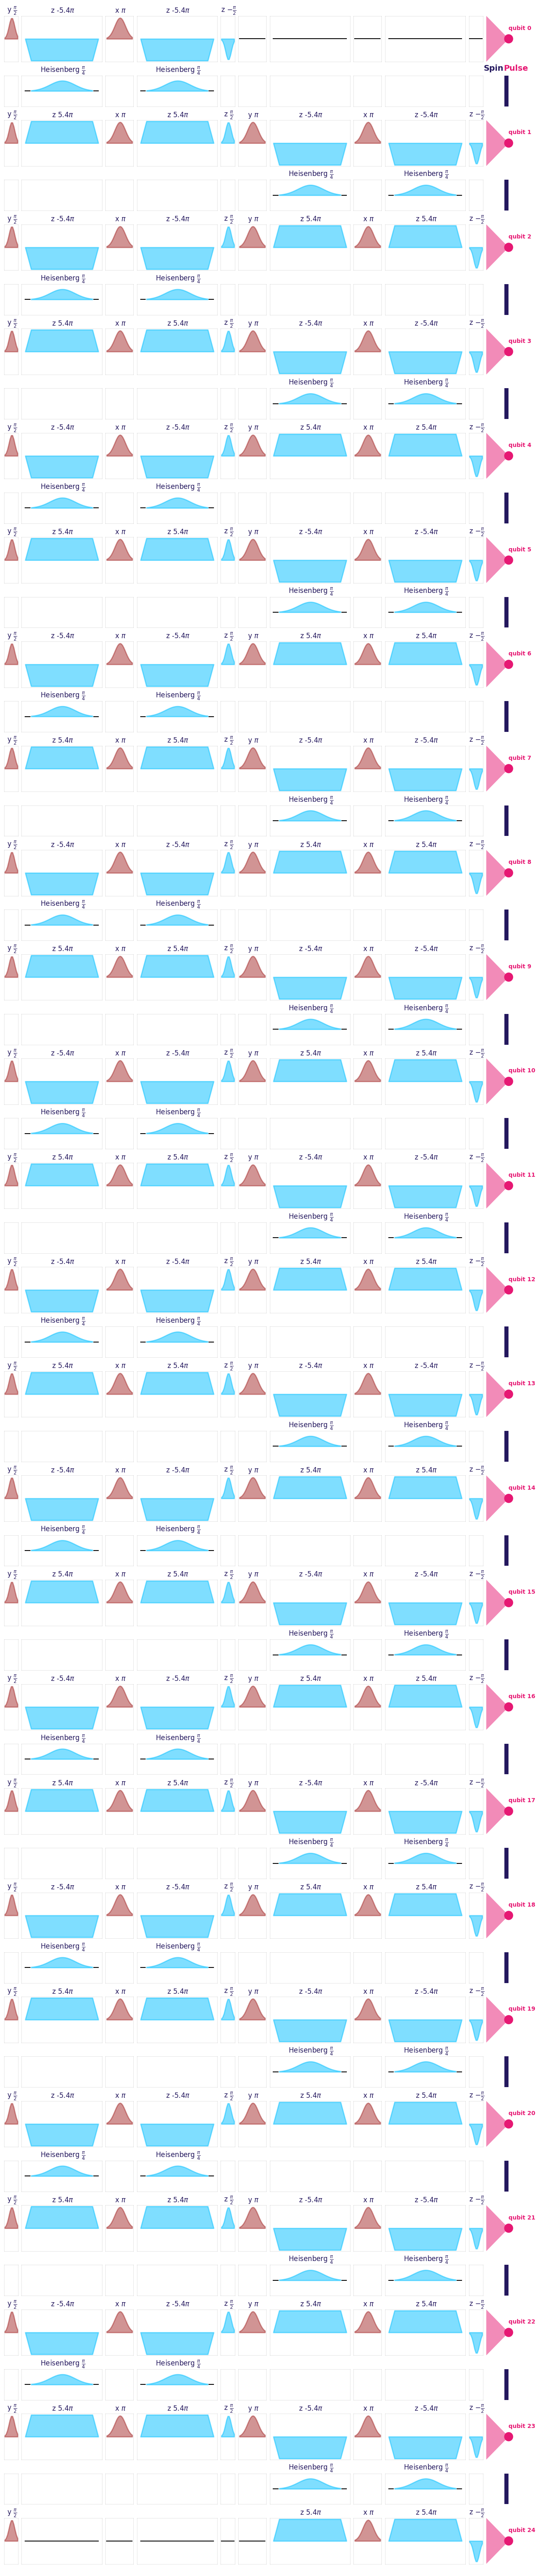

In [4]:
num_qubits = 25
pulse_circuit = get_pulse_circuit(num_qubits)
pulse_circuit.plot(get_hardware_specs(num_qubits))

Our pulse circuit can be converted to a gate-based description by calculating the unitary operator associator with each pulse. These unitaries are $2\times2$ or $4\times 4$ matrices, depending whether a pulse acts on one or two qubits.

In [5]:
implemented_circ = pulse_circuit.to_circuit()
print(
    "The first gate of our circuit is described by the unitary matrix ",
    implemented_circ.data[0],
)

The first gate of our circuit is described by the unitary matrix  CircuitInstruction(operation=Instruction(name='unitary', num_qubits=1, num_clbits=0, params=[array([[ 0.70710678+0.j, -0.70710678+0.j],
       [ 0.70710678+0.j,  0.70710678+0.j]])]), qubits=(<Qubit register=(25, "q"), index=0>,), clbits=())


These unitary matrices can be loaded into any gate-based simulation. Here we illustrate this possiblity by loading our Qiskit circuit to Quimb and perform tensor-network simulations.

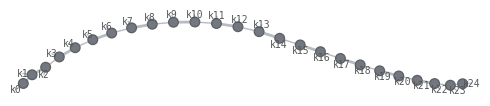

In [6]:
from spin_pulse.transpilation.utils import qiskit_to_quimb

quimb_circ = qiskit_to_quimb(pulse_circuit.to_circuit())
quimb_circ.psi.draw(show_inds=True)

To assess the level of performance of our pulse-level simulation, we will calculate the state fidelity between the exact cluster state wave-function, calculated using a Quimb "ideal" circuit, and the wavefunction obtained through the whole pulse-level decomposition and integration. Note that the fidelity is calculated efficiently in the tensor-network framework as the overlap between two matrix-product-states.

Without noise, the fidelity deviates only slightly from unity due to small non-adiabatic effects in the realization of the two-qubit gate

In [7]:
from quimb.tensor.circuit import CircuitMPS


def get_quimb_circ_ideal(num_qubits: int) -> CircuitMPS:
    """Build an ideal Quimb MPS circuit used as a reference state.

    The circuit applies a Hadamard gate on each qubit, followed by a chain of
    nearest-neighbor CZ gates (0-1, 1-2, ..., n-2-(n-1)). This produces a simple
    entangled target state that can be used to benchmark noisy simulations.

    Parameters:
        num_qubits: Number of qubits in the circuit.

    Returns:
        A `CircuitMPS` circuit implementing the ideal reference preparation.

    """
    quimb_circ_ideal = CircuitMPS(num_qubits)
    for i in range(num_qubits):
        quimb_circ_ideal.apply_gate("H", i)
    for i in range(num_qubits - 1):
        quimb_circ_ideal.apply_gate("CZ", i, i + 1)
    return quimb_circ_ideal


quimb_circ_ideal = get_quimb_circ_ideal(num_qubits)
print("Quimb fidelity ", my_quimb_fidelity(pulse_circuit, quimb_circ_ideal))

Quimb fidelity  0.9999799024271986


Adding a noise-model, the fidelity gets quickly degraded for large-qubit number

In [8]:
from spin_pulse import ExperimentalEnvironment
from spin_pulse.environment.noise import NoiseType

hardware_specs = get_hardware_specs(num_qubits)
exp_env = ExperimentalEnvironment(
    hardware_specs, NoiseType.PINK, T2S=1000, duration=2**14, segment_duration=2**14
)

In [9]:
print(
    "Averaged Quimb fidelity ",
    pulse_circuit.averaging_over_samples(my_quimb_fidelity, exp_env, quimb_circ_ideal),
)

Averaged Quimb fidelity  0.9504790212518891


Let us conclude this notebook by a scaling analysis of the fidelity as a function of number of qubits and coherence time $T_2^*$.

In [10]:
num_qubits = [10, 20, 50, 100]
T2S = [100, 200, 300, 400]
nx = len(num_qubits)
ny = len(T2S)
Fidelity = np.zeros((nx, ny))
for ix in range(nx):
    hardware_specs_ix = get_hardware_specs(num_qubits[ix])
    quimb_circ_ideal = get_quimb_circ_ideal(num_qubits[ix])
    pulse_circuit = get_pulse_circuit(num_qubits[ix])
    for iy in range(ny):
        exp_env = ExperimentalEnvironment(
            hardware_specs_ix,
            NoiseType.PINK,
            T2S=T2S[iy],
            duration=2**14,
            segment_duration=2**14,
        )
        Fidelity[ix, iy] = pulse_circuit.averaging_over_samples(
            my_quimb_fidelity, exp_env, quimb_circ_ideal
        )
        print(f"N={num_qubits[ix]} T_2^*={T2S[iy]}")

N=10 T_2^*=100


N=10 T_2^*=200


N=10 T_2^*=300


N=10 T_2^*=400


N=20 T_2^*=100


N=20 T_2^*=200


N=20 T_2^*=300


N=20 T_2^*=400


N=50 T_2^*=100


N=50 T_2^*=200


N=50 T_2^*=300


N=50 T_2^*=400


N=100 T_2^*=100


N=100 T_2^*=200


N=100 T_2^*=300


N=100 T_2^*=400


We observe that the fidelity decays as $\mathcal{F}\sim\exp(-\alpha N/(T_2^*)^2)$. This can be understood as follows. Each gate is approximately affected by the noise with a gate fidelity $f\sim\exp(-\beta/(T_2^*)^2)$, and errors propagate approximately  independently leading to $\mathcal{F}\sim f^{\#_{gates}}$, with $\#_{gates}\propto N$ for such cluster state.

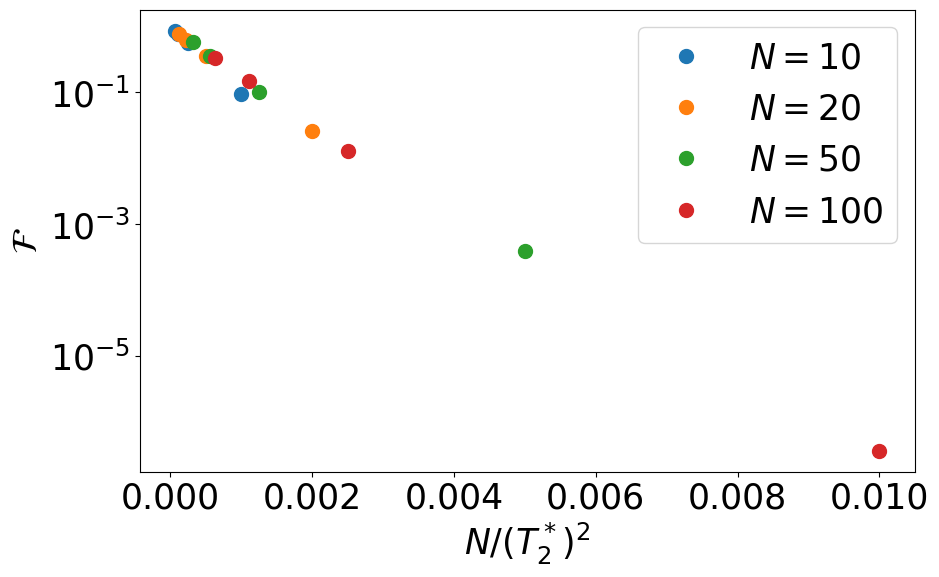

In [11]:
mpl.rcParams["font.size"] = 25
plt.figure(figsize=(10, 6))
for ix in range(nx):
    plt.plot(
        num_qubits[ix] / np.array(T2S) ** 2,
        Fidelity[ix, :],
        "o",
        label=f"$N={num_qubits[ix]}$",
        ms=10,
    )
plt.xlabel("$N/(T_2^*)^2$")
plt.ylabel(r"$\mathcal{F}$")
plt.legend(loc=0)
plt.yscale("log")
# plt.savefig('fig5.pdf',bbox_inches='tight')

With white noise, gate fidelities scale as $\exp(-\beta/T_2^*)$ resulting in an overall fidelity $\mathcal{F}\sim \exp(-N \alpha/T_2^*)$

In [12]:
num_qubits = [10, 20, 50, 100]
T2S = [500, 1000, 2000, 4000]
nx = len(num_qubits)
ny = len(T2S)
Fidelity = np.zeros((nx, ny))
for ix in range(nx):
    hardware_specs_ix = get_hardware_specs(num_qubits[ix])
    quimb_circ_ideal = get_quimb_circ_ideal(num_qubits[ix])
    pulse_circuit = get_pulse_circuit(num_qubits[ix])
    for iy in range(ny):
        exp_env = ExperimentalEnvironment(
            hardware_specs_ix,
            NoiseType.WHITE,
            T2S=T2S[iy],
            duration=2**14,
            segment_duration=1,
        )
        Fidelity[ix, iy] = pulse_circuit.averaging_over_samples(
            my_quimb_fidelity, exp_env, quimb_circ_ideal
        )
        print(
            f"$N={num_qubits[ix]} T_2^*={T2S[iy]}"
        )  # \mathcal{F}={Fidelity[ix,iy]}$")

$N=10 T_2^*=500


$N=10 T_2^*=1000


$N=10 T_2^*=2000


$N=10 T_2^*=4000


$N=20 T_2^*=500


$N=20 T_2^*=1000


$N=20 T_2^*=2000


$N=20 T_2^*=4000


$N=50 T_2^*=500


$N=50 T_2^*=1000


$N=50 T_2^*=2000


$N=50 T_2^*=4000


$N=100 T_2^*=500


$N=100 T_2^*=1000


$N=100 T_2^*=2000


$N=100 T_2^*=4000


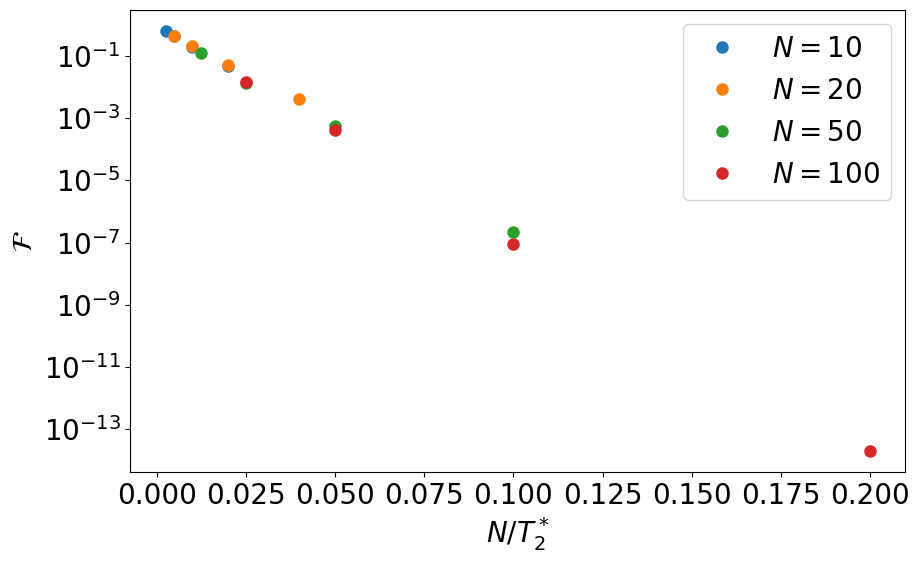

In [13]:
mpl.rcParams["font.size"] = 20
plt.figure(figsize=(10, 6))
for ix in range(nx):
    plt.plot(
        num_qubits[ix] / np.array(T2S),
        Fidelity[ix, :],
        "o",
        label=f"$N={num_qubits[ix]}$",
        ms=8,
    )
plt.xlabel("$N/T_2^*$")
plt.ylabel(r"$\mathcal{F}$")
plt.legend(loc=0)
plt.yscale("log")